### Neural Network Demo - Image Classifier

A python implementation of [Andrew Ng's neural network algorithm](https://www.coursera.org/learn/machine-learning/home/week/5) - classic, from-scratch implementation.

Resources:
1. [Katherine Bailey's post, 'Neural Nets in Python'](https://katbailey.github.io/post/neural-nets-in-python/)
2. [Keon Yong Lee's post, 'Deep Learning by Andrew Ng — Course 1: Neural Networks and Deep Learning'](https://medium.com/@keonyonglee/bread-and-butter-from-deep-learning-by-andrew-ng-course-1-neural-networks-and-deep-learning-41563b8fc5d8)
3. [Benjamin Lau's post, 'Andrew Ng's Machine Learning Course in Python'](https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9)

Later, may also implement a neural network for image classification using [TensorFlow](https://www.tensorflow.org/tutorials/images/classification)

In [105]:
from math import *
import numpy as np
import scipy.io as sio #use to import matlab dataset
from sklearn.model_selection import train_test_split #note, this differs from Katherine Bailey's code: sklearn.cross_validation
import matplotlib.pyplot as plt #note, using pyplot instead of pylab

In [8]:
#load dataset - 5000 handwritten digits between 0 and 9
mat_contents = sio.loadmat('data-ex4/ex4data1.mat')

In [27]:
# extract y labels:
# 0s were converted to 10s in the matlab data because matlab
# indices start at 1, so we need to change them back to 0s
y = mat_contents['y'] #a numpy ndarray
y = np.where(y == 10, 0, y)
print('size: ',y.shape)
y

size:  (5000, 1)


array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

In [28]:
#take the transform of the y labels - converts from column to row vector
y = y.reshape((y.shape[0],)) 
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [36]:
X = mat_contents['X']
X.shape

(5000, 400)

In [39]:
#split data: 70% data for training, 30% for testing:
X_train, X_test, y_train, y_test = train_test_split(mat_contents['X'], y,test_size=0.3,random_state=10) 
print('No. training examples:',y_train.shape[0])
print('No. test examples:', y_test.shape[0])

No. training examples: 3500
No. test examples: 1500


In [ ]:
## define a cross-validation set? come back to this
#X_train, X_val = X_train[:-1000], X_train[-1000:]
#y_train, y_val = y_train[:-1000], y_train[-1000:]

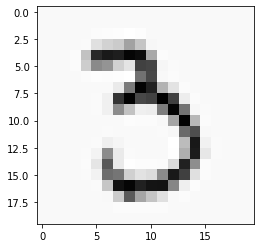

In [43]:
#inspect one of the X examples
plt.imshow(X_train[1301].reshape((20, 20), order='F'), cmap='Greys',  interpolation='nearest')

In [44]:
#use minimize function to optimize theta parameters - NEED THIS?
from scipy.optimize import minimize

### Implement a basic neural network

In [54]:
def sigmoid(X):
    '''Basic sigmoid function for logistic regression.'''
    return 1.0 / (1.0 + e ** (-1.0 * X)) 

In [74]:
def addBias(X):
    '''Adds the bias column to the matrix X'''
    return np.concatenate((np.ones((X.shape[0],1)), X), 1) 

In [72]:
def randInitializeWeights(L_in, L_out):
    '''Randomly initializes the weights for layer with the specified numbers of input and output nodes.'''
    #Randomly initialize the weights to small values
    epsilon_init = 0.1
    #generate random normal distribution with a mean of 0.5
    W = np.random.normal(0.5,size=(L_out, 1 + L_in)) * (2 * epsilon_init) - epsilon_init
    return W

In [85]:
def createInitialWeights(input_layer_size, hidden_layer_size, num_labels):
    '''Returns a single vector of randomly initialized theta1, theta2 parameters (weights) for the
    input layer and hidden layer.'''
    theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    return np.append(theta1.ravel(order='A'), theta2.ravel(order='A'))

In [80]:
def reshapeThetaMatrices(thetas, input_layer_size, hidden_layer_size, num_labels):
    '''Reshapes the two theta matrices from a single vector, given the
    size of the input layer, the hidden layer, and the number of
    labels in the output.'''
    theta1size = (input_layer_size + 1) * hidden_layer_size
    theta1 = np.reshape(thetas[:theta1size], (hidden_layer_size, input_layer_size + 1), order='A')
    theta2 = np.reshape(thetas[theta1size:], (num_labels, hidden_layer_size + 1), order='A')
    return theta1, theta2

In [82]:
def oneHotEncode(y, num_classes):
    '''Converts y vector of labels via one-hot encoding to matrix of classes'''
    y = y.reshape((y.shape[0],1))
    ycols = np.tile(y, (1, num_classes))
    m, n = ycols.shape
    indices = np.tile(np.arange(num_classes).reshape((1,num_classes)), (m, 1))
    ymat = indices == ycols
    return ymat.astype(int)

In [84]:
#Test oneHotEncode function
oneHotEncode(y,10)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

### Train neural network with forward propagation, prediction, cost calculation, back propagation, update of parameters

In [ ]:
def train(X_train, y_train, num_labels, hidden_layer_size, lmda, maxIter):
    '''Trains a basic neural network, assuming 3 layers: input, hidden, output. 
    Returns parameters (weights) to use to predict new data.'''
    input_layer_size = X_train.shape[1]
    initial_weights = createInitialWeights(input_layer_size, hidden_layer_size, num_labels)
    
    if y_train.ndim == 1:
        # Convert the y labels to one-hot vectors.
        y_train = oneHotEncode(y_train, num_labels)

    ## reshapeThetaMatrices? 
    
    def getActivations(theta1, theta2):
        '''Given theta parameters for the input layer and hidden layer, calulate the 
        activation values for the hidden layer (a2) and the output layer (a3).'''
        a1 = addBias(X_train)
        z2 = np.dot(a1,theta1.T)
        a2 = np.concatenate((np.ones((z2.shape[0],1)), sigmoid(z2)), 1)
        # a2 is an m x num_hidden+1 matrix, Theta2 is a num_labels x
        # num_hidden+1 matrix
        z3 = np.dot(a2,theta2.T)
        a3 = sigmoid(z3) # Now we have an m x num_labels matrix
        return a2, a3
    
    def costFunction(thetas):
        '''Cost function to be minimized with respect to weights.'''
        m = X_train.shape[0]
        
        theta1, theta2 = reshapeThetaMatrices(thetas, input_layer_size, hidden_layer_size, num_labels)
        a2, a3 = getActivations(theta1, theta2)
        
        h = a3 #hypothesis
        
        #calculate cost without regularization
        cost = (1/m) * sum((-y_train * log(h)) - ((1 - y_train) * log(1-h)))
        
        
        # Regularization
        thetasq = sum(theta1[:,1:(input_layer_size + 1)]**2) + sum(theta2[:,1:hidden_layer_size + 1]**2)
        reg = (lmda / float(2*m)) * thetasq
        print("Training loss:\t\t{:.6f}".format(cost))
        return cost + reg
    
    
    # START HERE...

In [ ]:
# code below is testing the individual functions above

In [94]:
thetas = createInitialWeights(400, 25, 10)
theta1,theta2=reshapeThetaMatrices(thetas, 400, 25, 10)

In [95]:
a1 = addBias(X_train)
z2 = np.dot(a1,theta1.T)

In [100]:
a2 = np.concatenate((np.ones((z2.shape[0],1)), sigmoid(z2)), 1)
z3 = np.dot(a2,theta2.T)
a3 = sigmoid(z3) # Now we have an m x num_labels matrix

In [109]:
    if y_train.ndim == 1:
        # Convert the y labels to one-hot vectors.
        y_train = oneHotEncode(y_train, 10)

In [118]:
m = X_train.shape[0]
h=a3
J = (1/m) * sum((-y_train * np.log(h)) - ((1 - y_train) * np.log(1-h)))

In [119]:
J #START HERE. MEANT TO BE A VECTOR?

array([0.48767678, 0.56641389, 0.58968549, 0.54983891, 0.80041181,
       0.78703355, 0.41088577, 0.83260027, 0.59141212, 0.65661981])